In [252]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, \
    Embedding,Dense,Flatten,Dot,BatchNormalization,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping
import matplotlib.pyplot as plt


In [253]:
# !pip install matplotlib

In [214]:
os.getcwd()

'/Users/amir/Desktop/GitHub/MLOPs/notebook'

In [215]:
INP_DIR = os.path.join('..','artifact','raw')

In [216]:
rating_df = pd.read_csv(INP_DIR+'/animelist.csv',low_memory=True, 
                        usecols=["user_id","anime_id","rating"])

In [217]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [218]:
len(rating_df)

5000000

In [219]:
n_ratings = rating_df['user_id'].value_counts()

In [220]:
rating_df = rating_df[rating_df['user_id'].isin((n_ratings[n_ratings>=400].index))].copy()

In [221]:
rating_df.shape

(3246641, 3)

In [222]:
min_rating = min(rating_df['rating'])
min_rating

0

In [223]:
max_rating = max(rating_df['rating'])
max_rating

10

In [224]:
avg_rating = np.mean(rating_df['rating'])
avg_rating

np.float64(4.122732695114736)

In [225]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [226]:
avg_rating = np.mean(rating_df['rating'])
avg_rating

np.float64(0.4122732695114729)

In [227]:
rating_df.duplicated().sum()

np.int64(0)

In [228]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [229]:
user_ids = rating_df['user_id'].unique().tolist()
user2user_encoder = {v:k for k,v  in enumerate(user_ids)}
user2user_decoder = {k:v for k,v  in enumerate(user_ids)}
rating_df['user'] = rating_df['user_id'].map(user2user_encoder)

In [230]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [231]:
n_users= len(user2user_encoder)
n_users

4203

In [232]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoder = {v:k for k,v  in enumerate(anime_ids)}
anime2anime_decoder = {k:v for k,v  in enumerate(anime_ids)}
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoder)

In [233]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [234]:
n_anime = len(anime2anime_encoder)
n_anime

17149

In [235]:
rating_df = rating_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [236]:
X = rating_df[['user','anime']].values
y = rating_df['rating'].values

In [237]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [238]:
X_train , X_test , y_train , y_test = (

    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]

)

In [239]:
len(X_train)

3245641

In [240]:
type(X_train)

numpy.ndarray

In [241]:
X_train_array = [X_train[: , 0] , X_train[: ,1]]
X_test_array = [X_test[: , 0] , X_test[: ,1]]

In [311]:
X_train_array

[array([3405, 4060, 1213, ...,  560, 3815, 2122]),
 array([ 688, 1518, 4963, ..., 1461, 1512, 1153])]

In [271]:
def RecommenderNet():
    embedding_size =128

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" , normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(4,kernel_initializer='he_normal')(x)
    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [272]:
model = RecommenderNet()

In [281]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 4)         │          8 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │          5 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,199,217 (31.28 MB)

 Trainable params: 2,733,071 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

 Optimizer params: 5,466,144 (20.85 MB)

In [282]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr



In [283]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)

In [284]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [280]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7983 - mae: 0.3810 - mse: 0.1963 - val_loss: 0.8036 - val_mae: 0.3881 - val_mse: 0.2011 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7952 - mae: 0.3797 - mse: 0.1950 - val_loss: 0.8060 - val_mae: 0.3886 - val_mse: 0.2018 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7893 - mae: 0.3773 - mse: 0.1926 - val_loss: 0.8023 - val_mae: 0.3879 - val_mse: 0.2005 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7807 - mae: 0.3743 - mse: 0.1894 - val_loss: 0.7965 - val_mae: 0.3866 - val_mse: 0.1984 - learning_rate: 3.4000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.7689 - mae: 0.3696 - mse: 0.1846 - val_loss: 0.7876 - val_mae: 0.3841 - val_mse: 0.1951 - learning_rate: 4.2000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7520 - mae: 0.3625 - mse: 0.1777 - val_loss: 0.7

In [285]:
model.load_weights(checkpoint_filepath)

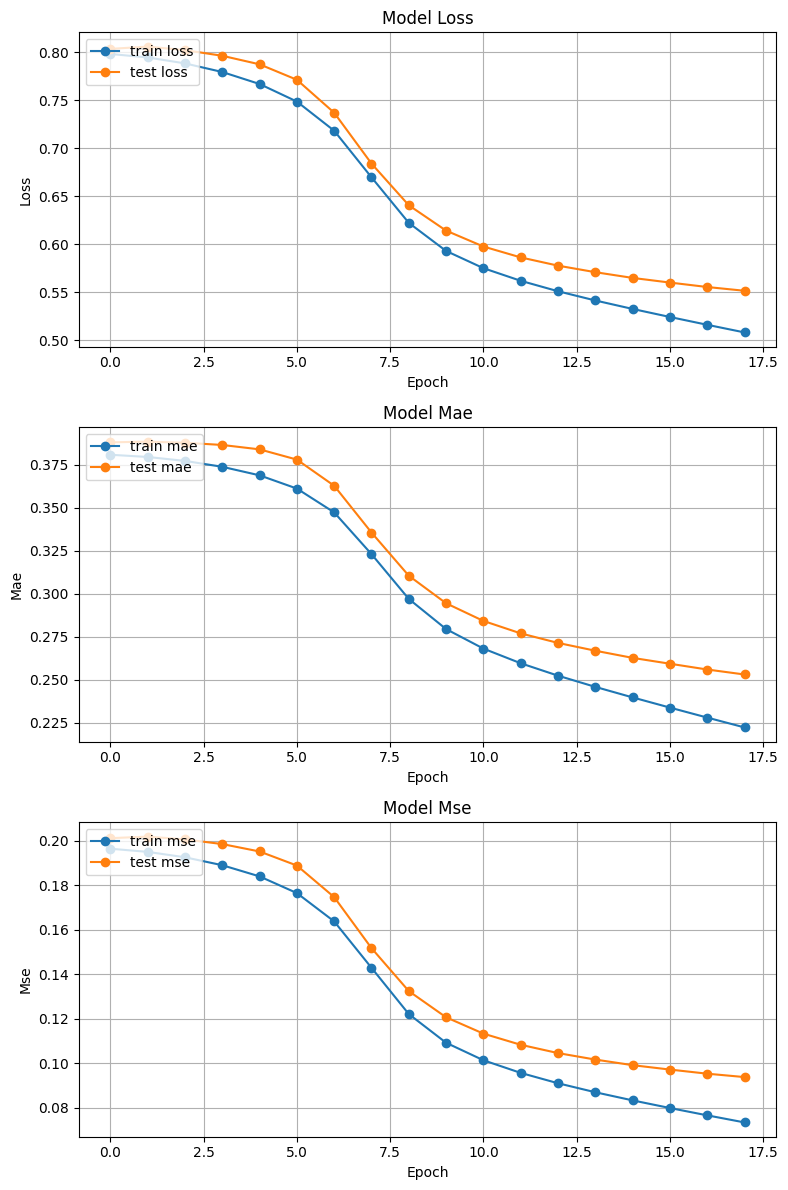

In [286]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [295]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1,1))


In [296]:
anime_embedding = extract_weights('anime_embedding', model)

In [298]:
user_embedding = extract_weights('user_embedding', model)

In [300]:
df =pd.read_csv(INP_DIR+'/anime.csv', low_memory=True)

In [302]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [303]:
df = df.replace('Unknown',np.nan)

In [305]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [306]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))